In [1]:
import os
import time
import numpy as np
import pandas as pd
import lightgbm as lgb

from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix
from sklearn.model_selection import validation_curve, train_test_split

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import gc
import scipy
from scipy import signal
from scipy.signal import butter, lfilter, freqz, stft
from scipy.fft import fft
import numpy as np
import pickle
import tensorflow as tf
from sklearn.metrics import accuracy_score, confusion_matrix, matthews_corrcoef, roc_auc_score, roc_curve 

# Functions

In [3]:
def plot_eeg(df, name='', save=False):
    fig, rows = plt.subplots(nrows=4, sharex=True, figsize=(17,10))
    fig.patch.set_visible(False)
    fig.tight_layout()

    for ax, col in zip(rows, df.columns):
        ax.plot(df[col])
        ax.title.set_text(col + "_" + name)
        ax.set_ylim(-150, 150)
        ax.patch.set_visible(False)
        
    if not save:
        plt.show()
    else:
        plt.savefig(f'figs/{name}.png')
        plt.close(fig)

In [4]:
def coluniza(a, nome):
    d = pd.DataFrame(a).T
    d.columns = [nome + "_" + str(col) for col in d.columns]
    return d

In [5]:
def save_to_file(objeto, nome_arquivo):
    with open(nome_arquivo, 'wb') as output:
        pickle.dump(objeto, output, pickle.HIGHEST_PROTOCOL)


def load_file(nome_arquivo):
    with open(nome_arquivo, 'rb') as input:
        objeto = pickle.load(input)
    return objeto

In [6]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [7]:
folder = './Data'

In [8]:
%%time
chunks = []
for f in os.listdir(folder):
    print(f)
    if 'Full_Negatives_7nov' in f:
        chunk = pd.read_hdf(os.path.join(folder, f))
        chunks.append(chunk)
neg = pd.concat(chunks, axis=0)

Full_Negatives_7nov0.hdf
Full_Negatives_7nov1.hdf
Full_Negatives_7nov2.hdf
Full_Positives_7nov.hdf
Wall time: 2min 33s


In [9]:
neg.columns

Index(['File', 'Paciente', 'Data', 'timestamp_start', 'Target'], dtype='object')

In [10]:
neg.shape

(30000, 5)

In [11]:
neg.head()

,File,Paciente,Data,timestamp_start,Target
0,danila_ramos.edf,RN DALILA RAMOS DOMINGUES,EEG C3-P3 EEG C4-P4 EEG P3-P4 EEG A1-...,0,1
1,danila_ramos.edf,RN DALILA RAMOS DOMINGUES,EEG C3-P3 EEG C4-P4 EEG P3-P4 EEG A1...,9000,1
2,danila_ramos.edf,RN DALILA RAMOS DOMINGUES,EEG C3-P3 EEG C4-P4 EEG P3-P4 EEG A1...,18000,1
3,danila_ramos.edf,RN DALILA RAMOS DOMINGUES,EEG C3-P3 EEG C4-P4 EEG P3-P4 EEG A1...,27000,1
4,danila_ramos.edf,RN DALILA RAMOS DOMINGUES,EEG C3-P3 EEG C4-P4 EEG P3-P4 EEG A1...,36000,1


In [12]:
neg['Data'].values[0]

,EEG C3-P3,EEG C4-P4,EEG P3-P4,EEG A1-A2
0,0.083503,-0.194469,-0.320255,0.093475
1,0.627561,-1.572063,-2.581153,0.856685
2,2.441086,-6.431905,-10.524846,3.505472
3,6.657532,-17.835315,-29.223078,9.768281
4,14.455691,-38.728811,-63.442064,21.216426
...,...,...,...,...
5995,7.382942,-8.689627,-5.391998,8.690808
5996,8.153691,-8.957492,-5.147577,9.117308
5997,8.697748,-8.880959,-4.597629,9.386676
5998,8.879101,-8.306962,-3.742154,9.341781


In [13]:
#Esqueci do target 0 rs
neg['Target'] = 0

In [14]:
pos = pd.read_hdf(os.path.join(folder, "Full_Positives_7nov.hdf"))

In [15]:
pos.shape, neg.shape

((1540, 5), (30000, 5))

In [16]:
#junta em um df
df = pd.concat([neg, pos]).reset_index(drop=True)

In [17]:
df['Target'].value_counts(dropna=False)

0    30000
1     1540
Name: Target, dtype: int64

In [18]:
#janelas de crise (alguns bebes tem muito pouco, não são usados para validar)
pos['File'].value_counts()

fabiana_1.edf           646
gilmara_cristina.edf    357
murilo_1.edf            211
remise_jean.edf          94
danila_ramos_4.edf       85
sarah_jadach.edf         84
danila_ramos.edf         56
juliana_lima_1.edf        5
juliana_lima_2.edf        1
marilene.edf              1
Name: File, dtype: int64

In [19]:
#janelas de não crise
df['File'].value_counts()

murilo_1.edf            11234
danila_ramos_5.edf       5550
danila_ramos_4.edf       3755
marilene.edf             2946
remise_jean.edf          2911
juliana_lima_2.edf       1945
fabiana_1.edf            1120
gilmara_cristina.edf      784
danila_ramos.edf          657
juliana_lima_1.edf        503
sarah_jadach.edf           84
danila_ramos_3.edf         51
Name: File, dtype: int64

# Testando em tudo
Sinais de 4 canais, 6000 amostras, frequencia = 200/sec

In [20]:
df['Data'].values[0].columns

Index(['EEG C3-P3', 'EEG C4-P4', 'EEG P3-P4', 'EEG A1-A2'], dtype='object')

In [21]:
stftArrayFinal = None

In [22]:
from tqdm import tqdm

In [23]:
fs = 200 # Hz
n = 5*fs # 5 seg

In [24]:
%%time
for i,row in tqdm(df.iterrows()):
    
    subDf = row['Data']
    dfArray = []
    #print(row['File'])
    
    for col in ['EEG C3-P3', 'EEG C4-P4', 'EEG P3-P4', 'EEG A1-A2']:
        
        #print(col)
        #print('Min:', np.min(np.abs(subDf[col].values)),'Max:', np.max(np.abs(subDf[col].values)))
        
        
        signalz = subDf[col].values/np.max(np.abs(subDf[col].values))
        signalz = butter_bandpass_filter(signalz, 0.5, 75, fs, order=6)
        dfArray.append(signalz)
    
    #print(' --- ')
    
    stftArray = []
    target = []

    for array in dfArray:

        subArray = [np.abs(np.fft.rfft(array[i:i + n]))/np.max(np.abs(np.fft.rfft(array[i:i + n]))) for i in range(0, len(array), n) if len(array[i:i + n]) == n]

        stftArray.append(np.array(subArray))
    
    stftArray = np.array(stftArray)
    
    if row['Target'] == 0:
        tar = np.ones((stftArray.shape[1],))
    else:
        tar = np.zeros((stftArray.shape[1],))
        
    if i == 0:
        stftArrayFinal = stftArray.copy()
        tgt = tar.copy()
    else:
        stftArrayFinal = np.concatenate((stftArrayFinal,stftArray),axis=1)
        tgt = np.concatenate((tgt,tar),axis=0)

31540it [26:01:01,  2.97s/it]   


Wall time: 1d 2h 1min 1s


In [27]:
arrayt = []
for t in tgt:
    if t == 0:
        arrayt.append([0,1])
    else:
        arrayt.append([1,0])
        
tgt  = np.array(arrayt)

In [28]:
stftArrayFinal = np.expand_dims(np.swapaxes(np.swapaxes(stftArrayFinal,0,1),1,2),axis=3)

In [29]:
save_to_file(stftArrayFinal, 'stftArray.pkl')
save_to_file(tgt, 'target.pkl')

## Model

In [30]:
del df, neg, pos

In [31]:
del subDf

In [32]:
import gc
gc.collect()

110

# Neural Network

In [12]:
stftArrayFinal = load_file('stftArray.pkl')
tgt = load_file('target.pkl')

In [13]:
#(10816, 201, 5, 1)
stftArrayFinal.shape

(189240, 501, 4, 1)

In [14]:
#input_shape = (img_rows, img_cols, 1)
input_shape = stftArrayFinal[0].shape
num_classes = 2
batch_size = 64
epochs = 300 #600
input_shape,num_classes

((501, 4, 1), 2)

In [15]:
# CRIANDO MODELO
inp = tf.keras.layers.Input(shape=input_shape)
x = tf.keras.layers.Conv2D(32*20, kernel_size=(4, 1), strides=(2, 1))(inp)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.AveragePooling2D(pool_size=(3, 1))(x)
x = tf.keras.layers.Dropout(rate=0.25)(x)
x = tf.keras.layers.Conv2D(32*20, kernel_size=(1, 4), strides=(1, 1))(x)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.Dropout(rate=0.25)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(rate=0.25)(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(rate=0.25)(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(rate=0.25)(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(rate=0.25)(x)
x = tf.keras.layers.Dense(16, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(rate=0.25)(x)
#
#
#
eeg = tf.keras.layers.Dense(num_classes,activation='softmax',name='output')(x)

model = tf.keras.models.Model(inputs=inp,outputs=[eeg])

In [16]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 501, 4, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 249, 4, 640)       3200      
_________________________________________________________________
activation (Activation)      (None, 249, 4, 640)       0         
_________________________________________________________________
average_pooling2d (AveragePo (None, 83, 4, 640)        0         
_________________________________________________________________
dropout (Dropout)            (None, 83, 4, 640)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 83, 1, 640)        1639040   
_________________________________________________________________
activation_1 (Activation)    (None, 83, 1, 640)        0     

In [12]:
model.compile(loss="categorical_crossentropy",
              optimizer='adam',
              metrics=['accuracy', 'AUC'])

In [13]:
# train, test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(range(0,len(tgt)),range(0,len(tgt)), test_size=0.2, random_state=42)

In [14]:
batch_size = 96

In [ ]:
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30,verbose=0, mode='min')
mcp_save = tf.keras.callbacks.ModelCheckpoint('bestAutoSave.hdf5', save_best_only=True, monitor='val_loss', mode='auto')
#reduce_lr_loss = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=0, min_delta=1e-4, mode='auto')

model.fit(
    stftArrayFinal[X_train,:,:,:], tgt[X_train],
    batch_size=batch_size,
    epochs=epochs,
    shuffle = True,
    validation_data=(stftArrayFinal[X_test,:,:,:], tgt[X_test]),
    callbacks=[mcp_save, earlyStopping],
    verbose=1
)

151392/151392 [==============================] - ETA: 2:04 - loss: 0.0109 - accuracy: 0.9962 - AUC: 0.99 - ETA: 2:03 - loss: 0.0109 - accuracy: 0.9962 - AUC: 0.99 - ETA: 2:03 - loss: 0.0109 - accuracy: 0.9962 - AUC: 0.99 - ETA: 2:03 - loss: 0.0109 - accuracy: 0.9962 - AUC: 0.99 - ETA: 2:03 - loss: 0.0109 - accuracy: 0.9962 - AUC: 0.99 - ETA: 2:03 - loss: 0.0109 - accuracy: 0.9962 - AUC: 0.99 - ETA: 2:02 - loss: 0.0109 - accuracy: 0.9962 - AUC: 0.99 - ETA: 2:02 - loss: 0.0109 - accuracy: 0.9962 - AUC: 0.99 - ETA: 2:02 - loss: 0.0109 - accuracy: 0.9962 - AUC: 0.99 - ETA: 2:02 - loss: 0.0109 - accuracy: 0.9962 - AUC: 0.99 - ETA: 2:02 - loss: 0.0109 - accuracy: 0.9962 - AUC: 0.99 - ETA: 2:01 - loss: 0.0109 - accuracy: 0.9962 - AUC: 0.99 - ETA: 2:01 - loss: 0.0109 - accuracy: 0.9962 - AUC: 0.99 - ETA: 2:01 - loss: 0.0109 - accuracy: 0.9962 - AUC: 0.99 - ETA: 2:01 - loss: 0.0110 - accuracy: 0.9962 - AUC: 0.99 - ETA: 2:01 - loss: 0.0110 - accuracy: 0.9962 - AUC: 0.99 - ETA: 2:00 - loss: 0.011

In [ ]:
model.save_weights("./modelo.hdf5")

## Test

In [ ]:
(pd.DataFrame(tgt))[0].value_counts(normalize=True)

In [ ]:
def cria_curva_roc_auc(modelo,df_verificacao,df_target):
    predictions = modelo.predict(df_verificacao)
    fpr, tpr, threshold = roc_curve(df_target, predictions[:,1])
    plt.figure(figsize=(8,8))
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc_score(df_target, predictions[:,1]))
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic REAIS')
    plt.legend(loc="lower right")
    plt.show()
    
def limiar_escore(modelo,df_verificacao,df_target):
    #Imprimindo limiar de Escore
    predictions = modelo.predict(df_verificacao)
    fpr, tpr, threshold = roc_curve(df_target, predictions[:,1])
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.loc[(roc.tf-0).abs().argsort()[:1]]
    print('Limiar que maxima especificidade e sensitividade:')
    print(list(roc_t['threshold']))
    #analisando modelo com novo limiar
    tn, fp, fn, tp = confusion_matrix(df_target, [1 if item>=list(roc_t['threshold'])[0] else 0 for item in predictions[:,1]]).ravel()
    Precision = tp/(tp+fp)
    Recall = tp/(tp+fn)
    acuracia = (tp+tn)/(tn+fp+fn+tp)
    F = (2*Precision*Recall)/(Precision+Recall)
    print('Precision',Precision)
    print('Recall',Recall)
    print('Acuracia',acuracia)
    print('F-Score',F)
    print('Roc-AUC', roc_auc_score(df_target, predictions[:,1]))

In [ ]:
cria_curva_roc_auc(model,stftArrayFinal[X_train,:,:,:],tgt[X_train,1])

In [ ]:
limiar_escore(model,stftArrayFinal[X_train,:,:,:],tgt[X_train,1])

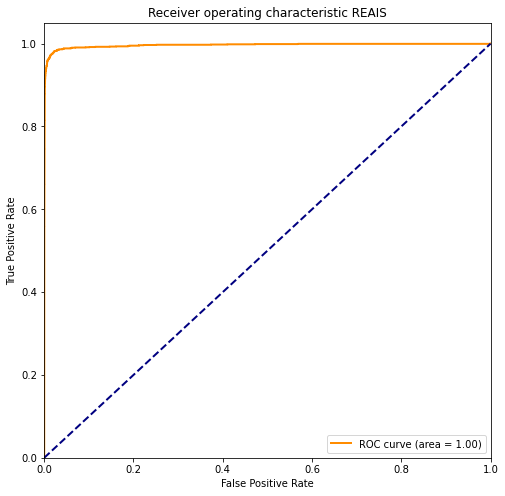

In [ ]:
cria_curva_roc_auc(model,stftArrayFinal[X_test,:,:,:],tgt[X_test,1])

In [ ]:
limiar_escore(model,stftArrayFinal[X_test,:,:,:],tgt[X_test,1])

Limiar que maxima especificidade e sensitividade:
[0.0017901735845953226]
Precision 0.699177438307873
Recall 0.9786184210526315
Acuracia 0.9786778693722258
F-Score 0.8156271418779986
Roc-AUC 0.9960730446880445


# Using Lime to Detect Best Samples array

In [17]:
import lime

In [18]:
from lime import lime_image

In [19]:
from skimage.segmentation import mark_boundaries

In [20]:
def new_predict_fn(images):
    images = images[:,:,:,0]
    #print(images.shape)
    #print(np.expand_dims(images,axis=3).shape)
    #print(model.predict(np.expand_dims(images,axis=3)))
    return model.predict(np.expand_dims(images,axis=3))

In [21]:
model.load_weights('bestAutoSave.hdf5')

In [22]:
explainer = lime_image.LimeImageExplainer()

In [23]:
randIntArray = np.random.randint(0,189240,size=5000)

In [24]:
heatmapArray = []
for i in tqdm(randIntArray):
    explanation = explainer.explain_instance( stftArrayFinal[i,:,:,0], new_predict_fn, top_labels=5, hide_color=0, num_samples=100)
    ind =  explanation.top_labels[0]
    #Map each explanation weight to the corresponding superpixel
    dict_heatmap = dict(explanation.local_exp[ind])
    heatmapArray.append(np.vectorize(dict_heatmap.get)(explanation.segments.T))

In [25]:
save_to_file(heatmapArray,'heatmapArray.pkl')

In [26]:
np.array(heatmapArray).shape

(5000, 4, 501)

In [27]:
heat = np.mean(np.array(heatmapArray)[list(np.where(tgt[randIntArray,0] == 1 )[0])],axis=0)

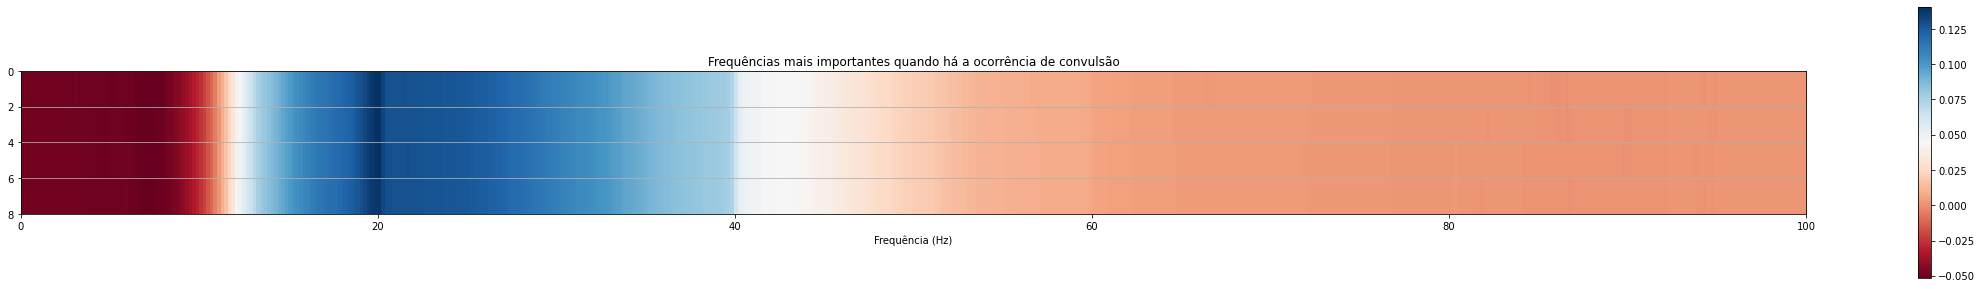

In [28]:
#Plot. The visualization makes more sense if a symmetrical colorbar is used.
plt.figure(figsize=(40,5))
plt.imshow(heat, cmap = 'RdBu', vmin  = heat.min(), vmax = heat.max(),extent=[0, 100, 8, 0],resample=True)
plt.title('Frequências mais importantes quando há a ocorrência de convulsão')
plt.grid(axis='y')
plt.xlabel('Frequência (Hz)')
plt.colorbar()

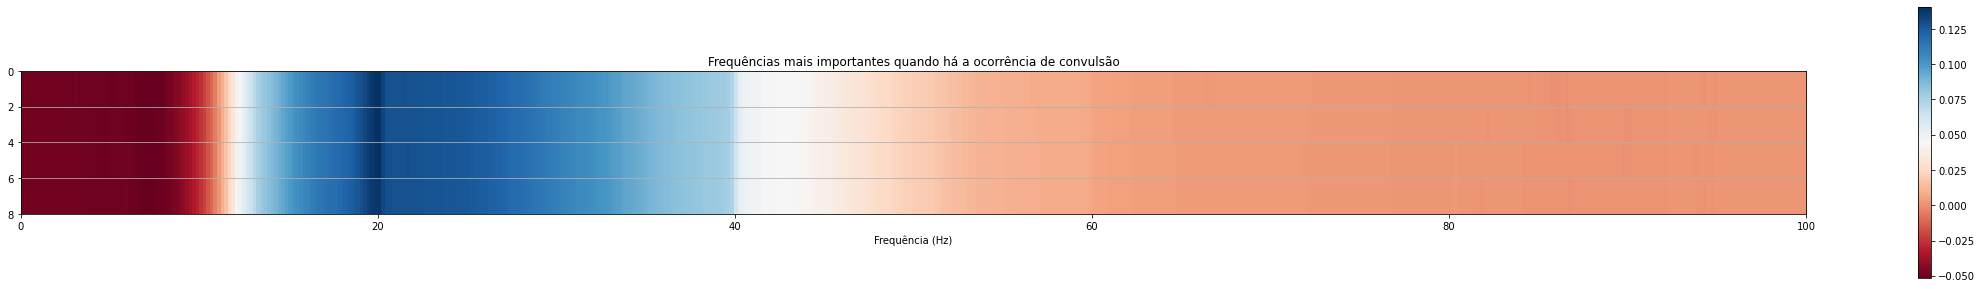

In [29]:
ax = plt.figure(figsize=(40,5))
ax = plt.imshow(heat, cmap = 'RdBu', vmin  = heat.min(), vmax = heat.max(),extent=[0, 100, 8, 0],resample=True)
ax = plt.title('Frequências mais importantes quando há a ocorrência de convulsão')
ax = plt.grid(axis='y')
ax = plt.xlabel('Frequência (Hz)')
ax = plt.colorbar()
plt.savefig('convulsao.png')

In [30]:
heat = np.mean(np.array(heatmapArray)[list(np.where(tgt[randIntArray,0] == 0 )[0])],axis=0)

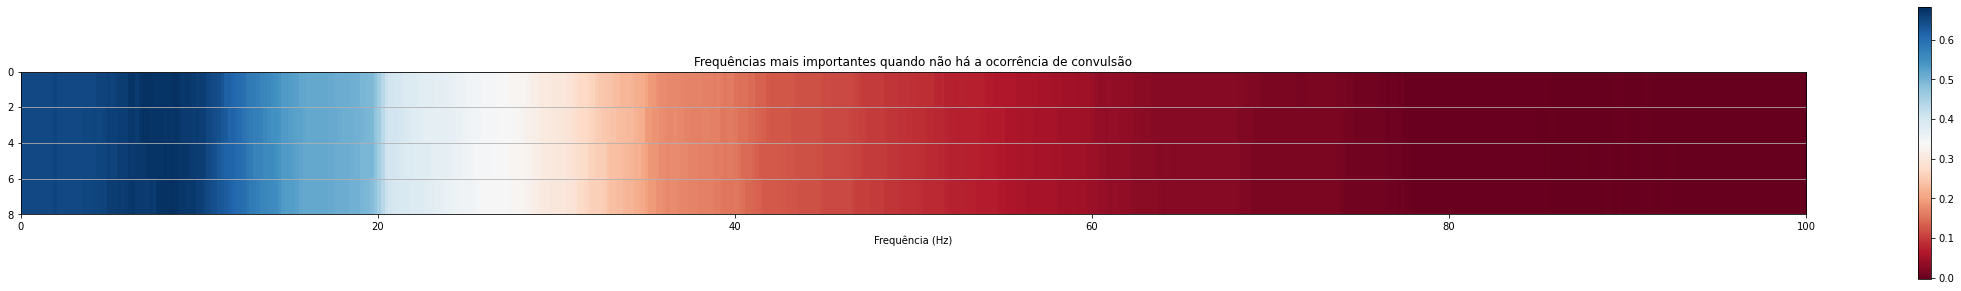

In [31]:
#Plot. The visualization makes more sense if a symmetrical colorbar is used.
plt.figure(figsize=(40,5))
plt.title('Frequências mais importantes quando não há a ocorrência de convulsão')
plt.imshow(heat, cmap = 'RdBu', vmin  = heat.min(), vmax = heat.max(),extent=[0, 100, 8, 0],resample=True)
plt.grid(axis='y')
plt.xlabel('Frequência (Hz)')
plt.colorbar()

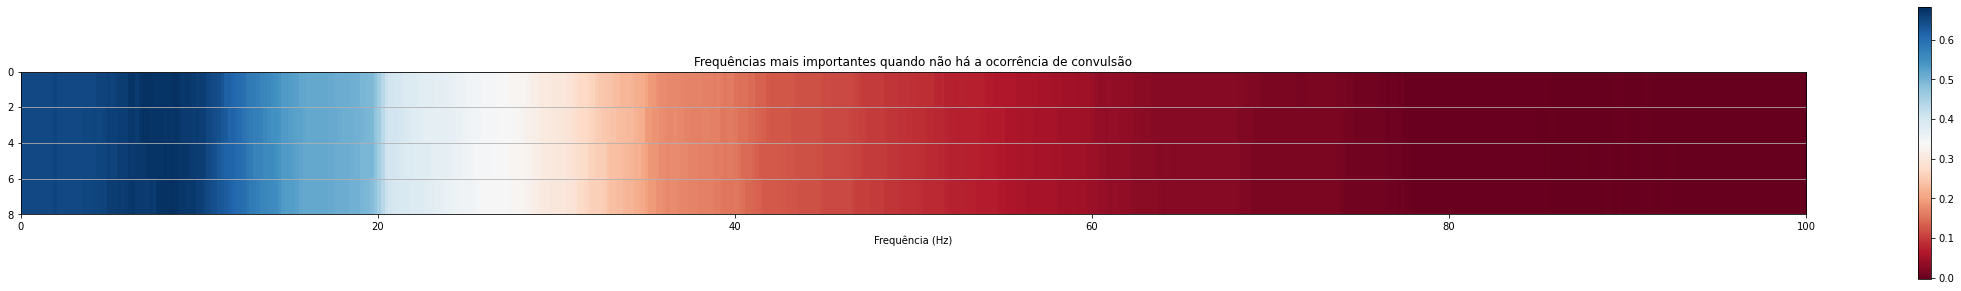

In [32]:
ax = plt.figure(figsize=(40,5))
ax = plt.imshow(heat, cmap = 'RdBu', vmin  = heat.min(), vmax = heat.max(),extent=[0, 100, 8, 0],resample=True)
ax = plt.title('Frequências mais importantes quando não há a ocorrência de convulsão')
ax = plt.grid(axis='y')
ax = plt.xlabel('Frequência (Hz)')
ax = plt.colorbar()
plt.savefig('naoconvulsao.png')

FIM